In [1]:
!pip install transformers
# https://huggingface.co/transformers/installation.html
!pip install sentencepiece
# https://pypi.org/project/sentencepiece/
# Python wrapper for SentencePiece. This API will offer the encoding, decoding and training of Sentencepiece.
!pip install Cython
# https://pypi.org/project/Cython/

     |████████████████████████████████| 3.1 MB 7.4 MB/s 
     |████████████████████████████████| 596 kB 28.5 MB/s 
     |████████████████████████████████| 61 kB 303 kB/s 
     |████████████████████████████████| 895 kB 34.7 MB/s 
     |████████████████████████████████| 3.3 MB 28.2 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 1.2 MB 5.2 MB/s 


In [2]:
import torch
if torch.cuda.is_available():
    device = torch.device("cuda:0") 
    print("GPU")
else:
    
    device = torch.device("cpu")
    print("CPU")

GPU


In [3]:
from google.colab import drive
drive.mount('/content/drive')

## Importing the required packages:

---



In [4]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

In [ ]:
import os
import sys
import transformers
from transformers.optimization import Adafactor 
import time
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AdamW,
    T5ForConditionalGeneration,
    T5Tokenizer,
    get_linear_schedule_with_warmup
)
import torch
import random
import re

#os.chdir('/content/drive/MyDrive/NLP-Project/')

In [ ]:
import pandas as pd
# Reading csv
data = pd.read_csv('dataset_2op.csv', header=None, names=['inputs', 'target'])
print(data.head(5))

                                      inputs  target
0  The sum of 875 and 2<extra_id_0>1 is 1096       2
1    The sum of 3<extra_id_0>3 and 27 is 360       3
2  The sum of <extra_id_0>55 and 728 is 1583       8
3  The sum of <extra_id_0>35 and 514 is 1249       7
4  The sum of 9<extra_id_0>7 and 728 is 1655       2


In [ ]:
data = data.sample(n = 35000, random_state = 42).reset_index(drop=True)

In [ ]:
from sklearn.model_selection import train_test_split

# Test and validation split
train, validation = train_test_split(data, test_size=0.3, random_state=42)
train, test = train_test_split(train, test_size=0.4, random_state=42)

data_train = train.reset_index(drop=True)
data_valid = validation.reset_index(drop=True)
data_test = test.reset_index(drop=True)

In [ ]:
# Initializing Parameters 
batch_size, num_of_epochs = 32, 50
num_of_batches = int(len(data_train)/batch_size)

<AxesSubplot:>

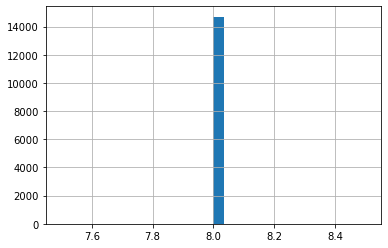

In [ ]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in data_train['inputs']]

pd.Series(seq_len).hist(bins = 30)

In [ ]:
# T5-base
tokenizer = T5Tokenizer.from_pretrained('t5-base')

model = T5ForConditionalGeneration.from_pretrained('t5-base', return_dict=True)
# moving the model to device(GPU/CPU)
model.to(device)

T5ForConditionalGeneration(
  (shared): Embedding(32128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseReluDense(
              (wi): Linear(in_features=768, out_features=3072, bias=False)
              (wo): Linear(in_features=3072, out_features=768, bias=False)
              (dropout): Dr

In [ ]:
token_lens = []

for txt in data_train.inputs:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))

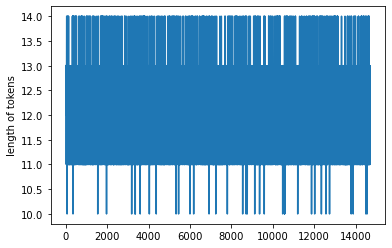

Maximum length is:  14


In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(1,len(token_lens)+1), token_lens)
plt.ylabel('length of tokens')
plt.show()

MAX_LEN = max(token_lens)
print("Maximum length is: ", MAX_LEN)

In [ ]:
MAX_LEN = 20

In [ ]:
def get_word_embeddings(data):
    input_ids=[]
    attention_masks = []
    for sent in data:
        encoded_sent = tokenizer.encode_plus(
            text=sent,  
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,                  # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            #return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True      # Return attention mask
            )
        
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

In [ ]:
# Run function `preprocessing_for_bert` on the train set and the validation set
train_inputs, train_masks = get_word_embeddings(data_train['inputs'])
val_inputs, val_masks = get_word_embeddings(data_valid['inputs'])
test_inputs, test_masks = get_word_embeddings(data_test['inputs'])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
D:\Software\Anaconda\lib\site-packages\transformers\tokenization_utils_base.py:2212: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
data_train['target_str'] = data_train['target'].astype(str)
data_valid['target_str'] = data_valid['target'].astype(str)
data_test['target_str'] = data_test['target'].astype(str)

In [ ]:
#convert lists to tensors
train_labels = get_word_embeddings(data_train['target_str'])[0]
val_labels = get_word_embeddings(data_valid['target_str'])[0]
test_labels = get_word_embeddings(data_test['target_str'])[0]

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler

batch_size = 32

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_dataloader = DataLoader(train_data, shuffle = True, batch_size = batch_size)

val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_dataloader = DataLoader(val_data, shuffle = True, batch_size = batch_size)

test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_dataloader = DataLoader(test_data, shuffle = True, batch_size = batch_size)

In [ ]:
#  Optimizer
# https://huggingface.co/transformers/model_doc/t5.html#overview
optimizer = Adafactor(
    model.parameters(),
    lr=5e-4, # Initializing the learning Rate as suggested in the T5 official documentation
    eps=(1e-8, 1e-3),
    clip_threshold=1.0,
    decay_rate=-0.3,
    beta1=None,
    weight_decay=0.0,
    relative_step=False,
    scale_parameter=False,
    warmup_init=False
)

In [ ]:
from IPython.display import HTML, display

# Setting the progress, with html as UI.
def progress(loss, value, max=100):
    return HTML(""" Batch loss :{loss}
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(loss=loss,value=value, max=max))

In [ ]:
def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    v_accuracy = []
    v_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        
        v_input_ids, v_attn_mask, v_labels = tuple(t.to(device) for t in batch)

        # print(v_input_ids.shape, v_labels.shape)

        val_outputs = model.generate(input_ids=v_input_ids, attention_mask=v_attn_mask)

        val_preds = [ tokenizer.decode(output, skip_special_tokens=True, clean_up_tokenization_spaces=True)
            for output in val_outputs]

        val_labels = [ tokenizer.decode(output, skip_special_tokens=True, clean_up_tokenization_spaces=True)
            for output in v_labels]
        
        # v_loss.append(val_outputs.loss)

        # Get the predictions
        # print(val_outputs.logits.shape)
        # val_preds = torch.argmax(val_outputs.logits, dim=1).flatten()
        # print(val_preds, val_labels)
        # Calculate the accuracy rate

        val_preds = np.array(val_preds)
        val_labels = np.array(val_labels)
        accuracy = ((val_preds == val_labels).sum() / len(val_labels)) * 100
        v_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    # v_loss = np.mean(v_loss)
    v_accuracy = np.mean(v_accuracy)

    return v_accuracy

In [ ]:
# Loading the configuration file for 't5-base' model
!wget https://s3.amazonaws.com/models.huggingface.co/bert/t5-base-config.json

In [ ]:
import gc

val_acc = 0
train_accuracy = 0

# Sets the module in training mode
model.train()

for epoch in range(1,num_of_epochs+1):
    print('Running epoch: {}'.format(epoch))
    running_loss=0
    # out = display(progress(1, num_of_batches+1), display_id=True)
    i =0 
    for batch in train_dataloader:
        input_ids, attn_mask, labels = tuple(t.to(device) for t in batch)

        # clear out the gradients of all Variables 
        optimizer.zero_grad()
        gc.collect()
        torch.cuda.empty_cache()

        # Forward propogation
        # print(model(input_ids=input_ids, attention_mask=attn_mask, labels=labels))
        outputs = model(input_ids=input_ids, attention_mask=attn_mask, labels=labels)

        loss = outputs.loss
        loss_num=loss.item()
        logits = outputs.logits
        running_loss+=loss_num
        # out.update(progress(loss_num,i, num_of_batches+1))

        # calculating the gradients
        loss.backward()

        # updating the params
        optimizer.step()

        print("Epoch ", epoch, "Batch ", i, "/", len(train_dataloader), " Training Loss ", loss_num)
        i += 1

    running_loss = running_loss/len(train_dataloader)
    # v_input_ids, v_attn_mask, v_labels = tuple(t.to(device) for t in data_valid)

    curr_accuracy = evaluate(model, val_dataloader)

    # print('Epoch: {} , Running loss: {}'.format(epoch,running_loss))
    print(f"{epoch + 1:^7} | {'-':^7} | {running_loss:^12.6f} | {curr_accuracy:^9.6f}")
    print("-"*70)

    if curr_accuracy > val_acc:
        val_acc = curr_accuracy
        # Saving the best model
        torch.save(model.state_dict(),'Best_Masked_NPM_5e_4.bin')


Running epoch: 1
Epoch  1 Batch  0 / 460  Training Loss  18.352741241455078
Epoch  1 Batch  1 / 460  Training Loss  8.818756103515625
Epoch  1 Batch  2 / 460  Training Loss  3.368025541305542
Epoch  1 Batch  3 / 460  Training Loss  1.6949059963226318
Epoch  1 Batch  4 / 460  Training Loss  1.0421080589294434
Epoch  1 Batch  5 / 460  Training Loss  0.7169634103775024
Epoch  1 Batch  6 / 460  Training Loss  0.5573797225952148
Epoch  1 Batch  7 / 460  Training Loss  0.41074055433273315
Epoch  1 Batch  8 / 460  Training Loss  0.3591325879096985
Epoch  1 Batch  9 / 460  Training Loss  0.38877731561660767
Epoch  1 Batch  10 / 460  Training Loss  0.4507334232330322
Epoch  1 Batch  11 / 460  Training Loss  0.307675302028656
Epoch  1 Batch  12 / 460  Training Loss  0.2719873785972595
Epoch  1 Batch  13 / 460  Training Loss  0.2523570656776428
Epoch  1 Batch  14 / 460  Training Loss  0.2265550196170807
Epoch  1 Batch  15 / 460  Training Loss  0.2451661080121994
Epoch  1 Batch  16 / 460  Training

In [ ]:
evaluate(model, val_dataloader)

92.76215805471125

In [ ]:
evaluate(model, test_dataloader)

92.59975570032573

## Fine Tuning - In Domain data (3-digit)


In [ ]:
data = pd.read_csv('finetune_inter_dataset.csv', header=None, names=['inputs', 'target'])

In [ ]:
data_inter = data.sample(n = 40000, random_state = 42).reset_index(drop=True)

train_inter, validation_inter = train_test_split(data_inter, test_size=0.3, random_state=42)
train_inter, test_inter = train_test_split(train_inter, test_size=0.4, random_state=42)

data_train_inter = train_inter.reset_index(drop=True)
data_valid_inter = validation_inter.reset_index(drop=True)
data_test_inter = test_inter.reset_index(drop=True)

# Run function `preprocessing_for_bert` on the train set and the validation set
train_inputs_inter, train_masks_inter = get_word_embeddings(data_train_inter['inputs'])
val_inputs_inter, val_masks_inter = get_word_embeddings(data_valid_inter['inputs'])
test_inputs_inter, test_masks_inter = get_word_embeddings(data_test_inter['inputs'])

data_train_inter['target_str'] = data_train_inter['target'].astype(str)
data_valid_inter['target_str'] = data_valid_inter['target'].astype(str)
data_test_inter['target_str'] = data_test_inter['target'].astype(str)

#convert lists to tensors
train_labels_inter = get_word_embeddings(data_train_inter['target_str'])[0]
val_labels_inter = get_word_embeddings(data_valid_inter['target_str'])[0]
test_labels_inter = get_word_embeddings(data_test_inter['target_str'])[0]

batch_size = 32

train_data_inter = TensorDataset(train_inputs_inter, train_masks_inter, train_labels_inter)
train_dataloader_inter = DataLoader(train_data_inter, shuffle = True, batch_size = batch_size)

val_data_inter = TensorDataset(val_inputs_inter, val_masks_inter, val_labels_inter)
val_dataloader_inter = DataLoader(val_data_inter, shuffle = True, batch_size = batch_size)

test_data_inter = TensorDataset(test_inputs_inter, test_masks_inter, test_labels_inter)
test_dataloader_inter = DataLoader(test_data_inter, shuffle = True, batch_size = batch_size)

In [ ]:
data_inputs_inter, data_masks_inter = get_word_embeddings(data_inter['inputs'])
data_inter['target_str'] = data_inter['target'].astype(str)
data_labels_inter = get_word_embeddings(data_inter['target_str'])[0]
data_inter_loader = TensorDataset(data_inputs_inter, data_masks_inter, data_labels_inter)

In [ ]:
import gc

val_acc = 0
train_accuracy = 0

# Sets the module in training mode
model.train()

for epoch in range(1,num_of_epochs+1):
    print('Running epoch: {}'.format(epoch))
    running_loss=0
    # out = display(progress(1, num_of_batches+1), display_id=True)
    i =0 
    for batch in train_dataloader_inter:
        
        input_ids, attn_mask, labels = tuple(t.to(device) for t in batch)

        # clear out the gradients of all Variables 
        optimizer.zero_grad()
        gc.collect()
        torch.cuda.empty_cache()

        # Forward propogation
        # print(model(input_ids=input_ids, attention_mask=attn_mask, labels=labels))
        outputs = model(input_ids=input_ids, attention_mask=attn_mask, labels=labels)

        loss = outputs.loss
        loss_num=loss.item()
        logits = outputs.logits
        running_loss+=loss_num
        # out.update(progress(loss_num,i, num_of_batches+1))

        # calculating the gradients
        loss.backward()

        # updating the params
        optimizer.step()

        print("Epoch ", epoch, "Batch ", i, "/", len(train_dataloader_inter), " Training Loss ", loss_num)
        i += 1

    running_loss = running_loss/len(train_dataloader_inter)
    # v_input_ids, v_attn_mask, v_labels = tuple(t.to(device) for t in data_valid)
  
    curr_accuracy = evaluate(model, val_dataloader_inter)

    # print('Epoch: {} , Running loss: {}'.format(epoch,running_loss))
    print(f"{epoch + 1:^7} | {'-':^7} | {running_loss:^12.6f} | {curr_accuracy:^9.6f}")
    print("-"*70)

    if curr_accuracy > val_acc:
        val_acc = curr_accuracy
        # Saving the best model
        torch.save(model.state_dict(),'Best_FT_NPM.bin')


Running epoch: 1
Epoch  1 Batch  0 / 525  Training Loss  2.985936164855957
Epoch  1 Batch  1 / 525  Training Loss  2.743593692779541
Epoch  1 Batch  2 / 525  Training Loss  1.4515612125396729
Epoch  1 Batch  3 / 525  Training Loss  1.0928207635879517
Epoch  1 Batch  4 / 525  Training Loss  0.8163682818412781
Epoch  1 Batch  5 / 525  Training Loss  0.7651575207710266
Epoch  1 Batch  6 / 525  Training Loss  0.8548161387443542
Epoch  1 Batch  7 / 525  Training Loss  0.58290034532547
Epoch  1 Batch  8 / 525  Training Loss  0.567663311958313
Epoch  1 Batch  9 / 525  Training Loss  0.6161358952522278
Epoch  1 Batch  10 / 525  Training Loss  0.5279967784881592
Epoch  1 Batch  11 / 525  Training Loss  0.49468857049942017
Epoch  1 Batch  12 / 525  Training Loss  0.48673582077026367
Epoch  1 Batch  13 / 525  Training Loss  0.4951511025428772
Epoch  1 Batch  14 / 525  Training Loss  0.468118816614151
Epoch  1 Batch  15 / 525  Training Loss  0.44972237944602966
Epoch  1 Batch  16 / 525  Training L

In [ ]:
evaluate(model, val_dataloader_inter)

67.83333333333333

In [ ]:
evaluate(model, val_dataloader_inter)

67.83333333333333

In [ ]:
# Function to generate sentences from symptoms on the test dataset
def predictSum(text, target):
    model.eval()
    model.to("cpu")
    numbers = [num for num in text.split() if num.isdigit()]
    op1, op2 = numbers[0], numbers[1]
    maxlen = max(len(str(op1)), len(str(op2)))
    minlen = min(len(str(op1)), len(str(op2)))
    input_ids = tokenizer.encode(text, return_tensors="pt")  # Batch size 1
    # s = time.time()
    input_ids.to("cpu")
    outputs = model.generate(input_ids)
    prediction=tokenizer.decode(outputs[0]).replace('<pad>','').replace('</s>','')
    # elapsed = time.time() - s
    # print('Generated in {} seconds'.format(str(elapsed)[:4]))
    predictlen = len(str(prediction))
    tmp = [text, minlen, maxlen, predictlen, target, prediction]
    return tmp

In [ ]:
final_list = []
for index, row in data_test_inter.iterrows():
    tmp = predictSum(row['inputs'], row['target'])
    final_list.append(tmp)

In [ ]:
df_final = pd.DataFrame(final_list, columns=["text", "min_len", "max_len", "predict_len", "target", "predictions"])
df_final.to_csv('results_2num_bias_1.csv', index = False, header=None)

## Fine-Tuning - In-Domain data (With Bias)

In [ ]:
import pandas as pd
# Reading csv
data = pd.read_csv('finetune_inter_dataset.csv', header=None, names=['inputs', 'target'])
bias = pd.read_csv('finetune_bias_dataset.csv', header=None, names=['inputs', 'target'])

In [ ]:
from sklearn.model_selection import train_test_split
data_inter = data.sample(n = 40000, random_state = 42).reset_index(drop=True)
data_bias_train = bias[:4000]
data_bias_test = bias[4000:]

train_inter, validation_inter = train_test_split(data_inter, test_size=0.3, random_state=42)
train_inter, test_inter = train_test_split(train_inter, test_size=0.4, random_state=42)

frames_train = [train_inter, data_bias_train]
train_inter = pd.concat(frames_train)
frames_test = [test_inter, data_bias_test]
test_inter = pd.concat(frames_test)

data_train_inter = train_inter.reset_index(drop=True)
data_valid_inter = validation_inter.reset_index(drop=True)
data_test_inter = test_inter.reset_index(drop=True)

In [ ]:
# Initializing Parameters 
batch_size, num_of_epochs = 32, 25
num_of_batches = int(len(data_train_inter)/batch_size)

<AxesSubplot:>

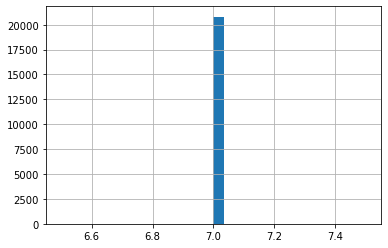

In [ ]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in data_train_inter['inputs']]

pd.Series(seq_len).hist(bins = 30)

In [ ]:
tokenizer = T5Tokenizer.from_pretrained('t5-base')
model = T5ForConditionalGeneration.from_pretrained('Best_Masked_NPM_5e_4.bin', return_dict=True, config='t5-base-config.json')
model.to(device)

T5ForConditionalGeneration(
  (shared): Embedding(32128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseReluDense(
              (wi): Linear(in_features=768, out_features=3072, bias=False)
              (wo): Linear(in_features=3072, out_features=768, bias=False)
              (dropout): Dr

In [ ]:
token_lens = []

for txt in data_train_inter.inputs:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))

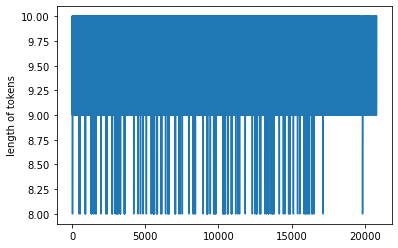

Maximum length is:  10


In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(1,len(token_lens)+1), token_lens)
plt.ylabel('length of tokens')
plt.show()

MAX_LEN = max(token_lens)
print("Maximum length is: ", MAX_LEN)

In [ ]:
MAX_LEN = 20

In [ ]:
def get_word_embeddings(data):
    input_ids=[]
    attention_masks = []
    for sent in data:
        encoded_sent = tokenizer.encode_plus(
            text=sent,  
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,                  # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            #return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True      # Return attention mask
            )
        
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler

# Run function `preprocessing_for_bert` on the train set and the validation set
train_inputs_inter, train_masks_inter = get_word_embeddings(data_train_inter['inputs'])
val_inputs_inter, val_masks_inter = get_word_embeddings(data_valid_inter['inputs'])
test_inputs_inter, test_masks_inter = get_word_embeddings(data_test_inter['inputs'])

data_train_inter['target_str'] = data_train_inter['target'].astype(str)
data_valid_inter['target_str'] = data_valid_inter['target'].astype(str)
data_test_inter['target_str'] = data_test_inter['target'].astype(str)

#convert lists to tensors
train_labels_inter = get_word_embeddings(data_train_inter['target_str'])[0]
val_labels_inter = get_word_embeddings(data_valid_inter['target_str'])[0]
test_labels_inter = get_word_embeddings(data_test_inter['target_str'])[0]

batch_size = 32

train_data_inter = TensorDataset(train_inputs_inter, train_masks_inter, train_labels_inter)
train_dataloader_inter = DataLoader(train_data_inter, shuffle = True, batch_size = batch_size)

val_data_inter = TensorDataset(val_inputs_inter, val_masks_inter, val_labels_inter)
val_dataloader_inter = DataLoader(val_data_inter, shuffle = True, batch_size = batch_size)

test_data_inter = TensorDataset(test_inputs_inter, test_masks_inter, test_labels_inter)
test_dataloader_inter = DataLoader(test_data_inter, shuffle = True, batch_size = batch_size)

In [ ]:
data_inputs_inter, data_masks_inter = get_word_embeddings(data_inter['inputs'])
data_inter['target_str'] = data_inter['target'].astype(str)
data_labels_inter = get_word_embeddings(data_inter['target_str'])[0]
data_inter_loader = TensorDataset(data_inputs_inter, data_masks_inter, data_labels_inter)

In [ ]:
import gc

val_acc = 0
train_accuracy = 0

# Sets the module in training mode
model.train()

for epoch in range(1,num_of_epochs+1):
    print('Running epoch: {}'.format(epoch))
    running_loss=0
    # out = display(progress(1, num_of_batches+1), display_id=True)
    i =0 
    for batch in train_dataloader_inter:
        
        input_ids, attn_mask, labels = tuple(t.to(device) for t in batch)

        # clear out the gradients of all Variables 
        optimizer.zero_grad()
        gc.collect()
        torch.cuda.empty_cache()

        # Forward propogation
        # print(model(input_ids=input_ids, attention_mask=attn_mask, labels=labels))
        outputs = model(input_ids=input_ids, attention_mask=attn_mask, labels=labels)

        loss = outputs.loss
        loss_num=loss.item()
        logits = outputs.logits
        running_loss+=loss_num
        # out.update(progress(loss_num,i, num_of_batches+1))

        # calculating the gradients
        loss.backward()

        # updating the params
        optimizer.step()

        print("Epoch ", epoch, "Batch ", i, "/", len(train_dataloader_inter), " Training Loss ", loss_num)
        i += 1

    running_loss = running_loss/len(train_dataloader_inter)
    # v_input_ids, v_attn_mask, v_labels = tuple(t.to(device) for t in data_valid)
  
    curr_accuracy = evaluate(model, val_dataloader_inter)

    # print('Epoch: {} , Running loss: {}'.format(epoch,running_loss))
    print(f"{epoch + 1:^7} | {'-':^7} | {running_loss:^12.6f} | {curr_accuracy:^9.6f}")
    print("-"*70)

    if curr_accuracy > val_acc:
        val_acc = curr_accuracy
        # Saving the best model
        torch.save(model.state_dict(),'Best_Bias_FT_NPM_2op_1.bin')


Running epoch: 1
Epoch  1 Batch  0 / 650  Training Loss  3.0917675495147705
Epoch  1 Batch  1 / 650  Training Loss  2.1983752250671387
Epoch  1 Batch  2 / 650  Training Loss  1.5348608493804932
Epoch  1 Batch  3 / 650  Training Loss  1.249096393585205
Epoch  1 Batch  4 / 650  Training Loss  0.8967719078063965
Epoch  1 Batch  5 / 650  Training Loss  0.8400863409042358
Epoch  1 Batch  6 / 650  Training Loss  0.765753448009491
Epoch  1 Batch  7 / 650  Training Loss  0.7456027269363403
Epoch  1 Batch  8 / 650  Training Loss  0.6314833164215088
Epoch  1 Batch  9 / 650  Training Loss  0.6265556216239929
Epoch  1 Batch  10 / 650  Training Loss  0.7831143140792847
Epoch  1 Batch  11 / 650  Training Loss  0.562079668045044
Epoch  1 Batch  12 / 650  Training Loss  0.5137105584144592
Epoch  1 Batch  13 / 650  Training Loss  0.5625909566879272
Epoch  1 Batch  14 / 650  Training Loss  0.5252841711044312
Epoch  1 Batch  15 / 650  Training Loss  0.5221134424209595
Epoch  1 Batch  16 / 650  Training L

In [ ]:
evaluate(model, val_dataloader_inter)

78.83333333333333

In [ ]:
evaluate(model, test_dataloader_inter)

65.55263157894737

In [ ]:
# Function to generate sentences from symptoms on the test dataset
def predictSum(text, target):
    model.eval()
    model.to("cpu")
    numbers = [num for num in text.split() if num.isdigit()]
    op1, op2 = numbers[0], numbers[1]
    maxlen = max(len(str(op1)), len(str(op2)))
    minlen = min(len(str(op1)), len(str(op2)))
    input_ids = tokenizer.encode(text, return_tensors="pt")  # Batch size 1
    # s = time.time()
    input_ids.to("cpu")
    outputs = model.generate(input_ids)
    prediction=tokenizer.decode(outputs[0]).replace('<pad>','').replace('</s>','')
    # elapsed = time.time() - s
    # print('Generated in {} seconds'.format(str(elapsed)[:4]))
    predictlen = len(str(prediction))
    tmp = [text, minlen, maxlen, predictlen, target, prediction]
    return tmp

In [ ]:
final_list = []
for index, row in data_test_inter.iterrows():
    tmp = predictSum(row['inputs'], row['target'])
    final_list.append(tmp)

In [ ]:
df_final = pd.DataFrame(final_list, columns=["text", "min_len", "max_len", "predict_len", "target", "predictions"])
df_final.to_csv('results_2num_bias_1.csv', index = False, header=None)

## Fine-Tuning - Extrapolation 4digit data

In [ ]:
tokenizer = T5Tokenizer.from_pretrained('t5-base')
model = T5ForConditionalGeneration.from_pretrained('Best_Bias_FT_NPM_2op_1.bin', return_dict=True, config='t5-base-config.json')
model.to(device)

In [ ]:
data = pd.read_csv('finetune_extra_dataset.csv', header=None, names=['inputs', 'target'])

In [ ]:
data_extra = data.sample(n = 5000, random_state = 42).reset_index(drop=True)

data_extra = data_extra.reset_index(drop=True)

# Run function `preprocessing_for_bert` on the train set and the validation set
inputs_extra, masks_extra = get_word_embeddings(data_extra['inputs'])

data_extra['target_str'] = data_extra['target'].astype(str)

#convert lists to tensors
labels_extra = get_word_embeddings(data_extra['target_str'])[0]

batch_size = 32

data_extra = TensorDataset(inputs_extra, masks_extra, labels_extra)
dataloader_extra = DataLoader(data_extra, shuffle = True, batch_size = batch_size)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


"\ntrain_extra, validation_extra = train_test_split(data_extra, test_size=0.3, random_state=42)\ntrain_extra, test_extra = train_test_split(train_extra, test_size=0.4, random_state=42)\n\ndata_train_extra = train_extra.reset_index(drop=True)\ndata_valid_extra = validation_extra.reset_index(drop=True)\ndata_test_extra = test_extra.reset_index(drop=True)\n\n# Run function `preprocessing_for_bert` on the train set and the validation set\ntrain_inputs_extra, train_masks_extra = get_word_embeddings(data_train_extra['inputs'])\nval_inputs_extra, val_masks_extra = get_word_embeddings(data_valid_extra['inputs'])\ntest_inputs_extra, test_masks_extra = get_word_embeddings(data_test_extra['inputs'])\n\ndata_train_extra['target_str'] = data_train_extra['target'].astype(str)\ndata_valid_extra['target_str'] = data_valid_extra['target'].astype(str)\ndata_test_extra['target_str'] = data_test_extra['target'].astype(str)\n\n#convert lists to tensors\ntrain_labels_extra = get_word_embeddings(data_train_e

In [ ]:
evaluate(model, dataloader_extra)

## Fine-Tuning - Extrapolation 5digit data

In [ ]:
data = pd.read_csv('finetune_extra_5_dataset.csv', header=None, names=['inputs', 'target'])

In [ ]:
data_extra = data.sample(n = 2000, random_state = 42).reset_index(drop=True)

data_extra = data_extra.reset_index(drop=True)

# Run function `preprocessing_for_bert` on the train set and the validation set
inputs_extra, masks_extra = get_word_embeddings(data_extra['inputs'])

data_extra['target_str'] = data_extra['target'].astype(str)

#convert lists to tensors
labels_extra = get_word_embeddings(data_extra['target_str'])[0]

batch_size = 32

data_extra = TensorDataset(inputs_extra, masks_extra, labels_extra)
dataloader_extra = DataLoader(data_extra, shuffle = True, batch_size = batch_size)

In [ ]:
evaluate(model, dataloader_extra)

28.273809523809526